In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.io import wavfile

In [3]:
samplerate_dry, dry_signal = wavfile.read('Audio files/guitar_02_dry_b16.wav')

In [4]:
len(dry_signal)

4672594

In [5]:
samplerate_dry

48000

In [6]:
samplerate_wet, wet_signal = wavfile.read('Audio files/guitar_02_wet_b16.wav')

In [7]:
wet_signal_mono = wet_signal

Text(0, 0.5, 'wet signal')

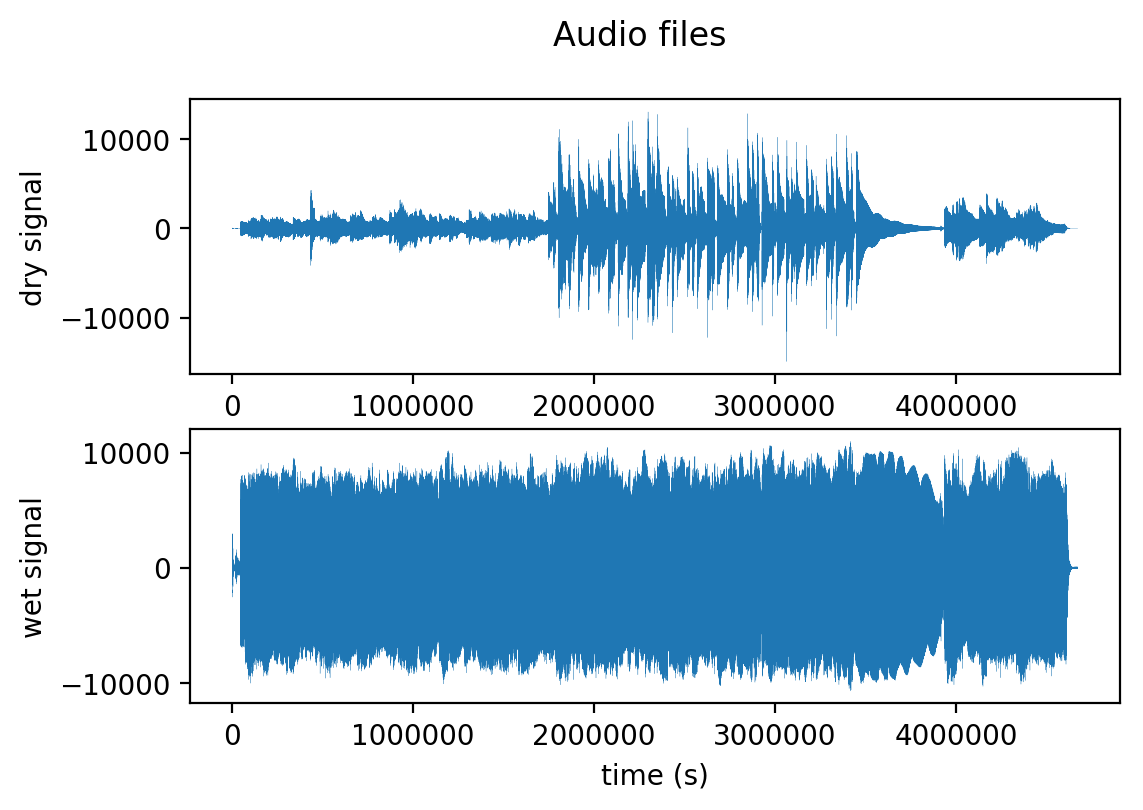

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=200,)
fig.suptitle('Audio files')

ax1.plot(dry_signal,lw=0.1)
ax1.set_ylabel('dry signal')

ax2.plot(wet_signal_mono,lw=0.1)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('wet signal')

In [9]:
#FFT parameters

# sampling frequency [Hz]
sample_rate = samplerate_dry

# time step [s]
t_step = 1/sample_rate

# buffer size (number of samples)
buffer = 256

# frequency interval [Hz] (in frequency domain)
f_step = sample_rate / buffer

In [10]:
dry_buffer = []
wet_buffer = []

for i0 in range(0,len(dry_signal)//buffer):
    
    shift = i0 * buffer
    
    dry_buffer.append(dry_signal[0 + shift : buffer + shift])
    wet_buffer.append(wet_signal_mono[0 + shift : buffer + shift])
    
dry_buffer = np.array(dry_buffer)
wet_buffer = np.array(wet_buffer)

total_buffer = np.append(dry_buffer,wet_buffer,axis=1)

In [11]:
dry_buffer.shape

(18252, 256)

In [12]:
wet_buffer.shape

(18252, 256)

In [13]:
dry_buffer_fft = []
wet_buffer_fft = []

#freq_samples = int(buffer/2 +1)

for i in range(0,len(dry_buffer)):
    
    fourier_dry = np.fft.rfft(dry_buffer[i,:])
    dry_modulus = np.abs(fourier_dry)
    dry_argument = np.angle(fourier_dry)
    
    total_dry = np.append(dry_modulus,dry_argument)
    
    dry_buffer_fft.append(total_dry)
    
    
    
    fourier_wet = np.fft.rfft(wet_buffer[i,:])
    wet_modulus = np.abs(fourier_wet)
    wet_argument = np.angle(fourier_wet)
    
    total_wet = np.append(wet_modulus,wet_argument)
    
    wet_buffer_fft.append(total_wet)
    
dry_buffer_fft = np.array(dry_buffer_fft)
wet_buffer_fft = np.array(wet_buffer_fft)

In [14]:
dry_buffer_fft.shape

(18252, 258)

In [15]:
wet_buffer_fft.shape

(18252, 258)

# Model

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import pandas as pd

In [17]:
class My_amp(nn.Module):
    def __init__(self, in_features=buffer+2, h1=6144, h2=4096, out_features=buffer+2):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        #self.fc3 = nn.Linear(h2,h3)             # hidden layer
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

In [18]:
torch.manual_seed(101)
model = My_amp()

# Model 2

# Train/test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(dry_buffer_fft, wet_buffer_fft, test_size=0.5, random_state=42)

In [20]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [21]:
X_train.shape[0]/9

1014.0

In [22]:
X_train[0:2].shape

torch.Size([2, 258])

# Model training

In [23]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [24]:
import time

epochs = 100
losses_train = []
losses_test = []
batches = 9
batch_size = int(X_train.shape[0]/batches)

for i in range(epochs):
    
    start_time = time.time()
    
    i+=1
    
    for b in range(0,batches):
        y_pred = model.forward(X_train[0+int(b*batch_size) : batch_size+int(b*batch_size)])
        loss_train = torch.sqrt(criterion(y_pred, y_train[0+int(b*batch_size) : batch_size+int(b*batch_size)]))
        #losses_train.append(loss_train)

        '''
        with torch.no_grad():
            y_val = model.forward(X_test)
            loss_test = torch.sqrt(criterion(y_val, y_test))
            losses_test.append(loss_test)

        '''

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
    
    stop_time = time.time() - start_time
    
    # a neat trick to save screen space:
    if i%10 == 1:
        print(f'epoch: {i:2}  loss_train: {loss_train.item():10.8f}  time: {stop_time} s')
        #print(f'epoch: {i:2}  loss_train: {loss_train.item():10.8f}  loss_test: {loss_test.item():10.8f} time: {stop_time} s')

epoch:  1  loss_train: 35744.02343750  time: 8.67707347869873 s
epoch: 11  loss_train: 31284.16601562  time: 7.674553871154785 s
epoch: 21  loss_train: 30400.55078125  time: 7.561990976333618 s
epoch: 31  loss_train: 29889.14062500  time: 7.496853590011597 s
epoch: 41  loss_train: 29514.30859375  time: 7.814370155334473 s
epoch: 51  loss_train: 29213.34179688  time: 7.5402398109436035 s
epoch: 61  loss_train: 28960.30468750  time: 7.578469514846802 s


KeyboardInterrupt: 

In [ ]:
plt.plot(range(epochs), losses_train)
#plt.plot(range(epochs), losses_test)
plt.ylabel('Loss')
plt.xlabel('epoch');

In [ ]:
# TO EVALUATE THE ENTIRE TEST SET
#with torch.no_grad():
    #y_val = model.forward(X_test)
    #loss = torch.sqrt(criterion(y_val, y_test))
#print(f'{loss:.8f}')

In [ ]:
torch.save(model.state_dict(), 'my_amp_sim3.pt')

In [ ]:
dry_in = torch.FloatTensor(dry_buffer_fft)
wet_out = torch.FloatTensor(wet_buffer_fft)

with torch.no_grad():
    y_val = model.forward(dry_in)
    loss = torch.sqrt(criterion(y_val, wet_out))
    
print(f'{loss:.8f}')

In [ ]:
y_val.shape

In [ ]:
import math
import cmath

my_range = int(buffer/2 + 1)

modulus_buffer = y_val[:,0:my_range]
argument_buffer = y_val[:,129:]

def P2R(radii, angles):
    return radii * cmath.exp(1j*angles)

In [ ]:
#modulus_buffer.shape
argument_buffer.shape

In [ ]:
#P2R(modulus_buffer[0,0],argument_buffer[0,0])
#modulus_buffer[0,0]
argument_buffer[0,0].item()

In [ ]:
output_fft = []

for i0 in range(0,len(modulus_buffer)):
    
    out = []
    
    for i1 in range(0,len(modulus_buffer[i0])):
        
        mag = modulus_buffer[i0,i1].item()
        arg = argument_buffer[i0,i1].item()
        out.append(P2R(mag,arg))
        
    output_fft.append(out)
    
output_fft = np.array(output_fft)

In [ ]:
output_fft.shape

In [ ]:
processed_signal = np.fft.irfft(output_fft)

In [ ]:
processed_signal.shape

In [ ]:
processed_signal[0,:5]

In [ ]:
processed_signal = np.array(processed_signal)

In [ ]:
processed_signal.shape

In [ ]:
processed_signal = processed_signal.flatten()

In [ ]:
processed_signal.shape

In [ ]:
plt.plot(processed_signal)

In [ ]:
#wavfile.write('test6.wav',48000,processed_signal)